# Deep Learning
## Summative assessment
### Coursework 2

#### Instructions

This coursework is released on **Wednesday 21st February 9.00** and is due by **Wednesday 6th March 23.59**. It is worth **40%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 10 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for a classification task using multimodal data.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and a PDF submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF copy of your executed notebook, in case the .ipynb file is corrupted for some reason. 

Upload a zip file containing your notebook and separate PDF file(s) to Coursera by the deadline above.

In [1]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras.layers import (Layer, Input, Dense, GRU, Embedding, Conv2D, BatchNormalization, Activation, GlobalMaxPooling2D, TextVectorization, StringLookup)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tabulate import tabulate

In [2]:
# You will need access to a GPU for this coursework

print(tf.config.list_physical_devices('GPU'))
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### The CLEVR Dataset

This assessment makes use of the [CLEVR Dataset](https://cs.stanford.edu/people/jcjohns/clevr/). This dataset is a visual question answering dataset, and consists of images with corresponding text questions and answers about the image.  

* Johnson, J., Hariharan, B., van der Maaten, L., Li, F.-F., Zitnick, C. L. & Girshick, R. (2016), "CLEVR: A Diagnostic Dataset for Compositional Language and Elementary Visual Reasoning", *IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 1988-1997.

The original dataset consists of a training set of 70,000 images and 699,989 questions, a validation set of 15,000 images and 149,991 questions, and a test set of 15,000 images and 14,988 questions. In this coursework you will work with a subset of the training and validation splits, which have been preprocessed and prepared for you. 

The data is stored in TFRecord format, which is a data format that is efficient for TensorFlow to work with. You can read about the TFRecord format [here](https://www.tensorflow.org/tutorials/load_data/tfrecord) if you are interested, but there is no need to find out about TFRecord for this assessment. The code to read in the TFRecord data to Dataset objects is provided for you below.

In [3]:
train_ds = tf.data.TFRecordDataset([os.path.join('../../../data_CW2/data', 'train', f) 
                                    for f in os.listdir(os.path.join('../../../data_CW2/data', 'train')) if f.endswith('tfrecords')])
val_ds = tf.data.TFRecordDataset([os.path.join('../../../data_CW2/data', 'val', f) 
                                    for f in os.listdir(os.path.join('../../../data_CW2/data', 'val')) if f.endswith('tfrecords')])

In [4]:
# The following helper function will parse the TFRecord files to return a dictionary of TensorFlow objects

def parse_function(example_proto):
    features = {
        "image": tf.io.FixedLenFeature((), tf.string),
        "question": tf.io.VarLenFeature(dtype=tf.string),
        "answer": tf.io.VarLenFeature(dtype=tf.string)
    }
    parsed_features = tf.io.parse_single_example(serialized=example_proto, features=features)
    parsed_features["question"] = tf.sparse.to_dense(parsed_features["question"])
    parsed_features["answer"] = tf.sparse.to_dense(parsed_features["answer"])
    image = tf.io.decode_raw(parsed_features["image"], tf.int32)
    image = tf.reshape(image, [224, 224, 3])
    parsed_features["image"] = image
    return parsed_features

In [5]:
train_ds = train_ds.map(parse_function)
val_ds = val_ds.map(parse_function)

In [6]:
train_ds.element_spec

{'answer': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'question': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'image': TensorSpec(shape=(224, 224, 3), dtype=tf.int32, name=None)}

Your task in this assessment is to develop a deep learning model to predict the answer for a given question about an image.

You will need to implement special customised layers and a sophisticated model architecture, making use of both CNN and RNN models. You will process the data, train and evaluate the specified model, and then write a proposal for your own modified architecture.

### Question 1 (Total 15 marks)

The training and validation datasets both return dictionaries with keys `"image"`, `"question"` and `"answer"`. For each image, there are multiple questions and answers. The question and answer entries in the dictionary are both lists of strings of the same length, with aligned questions and answers for the given image. The image entry is a 224x224x3 integer Tensor. These images have been resized from the original size of 480x320, so they appear slightly stretched (this can be ignored). 

a) Inspect the contents of the dataset by displaying at least one image and it's corresponding questions and answers.

**(3 marks)**

In [7]:
for ele in train_ds.take(1):
    eg_q, eg_a, eg_i = ele["question"], ele["answer"], ele["image"]


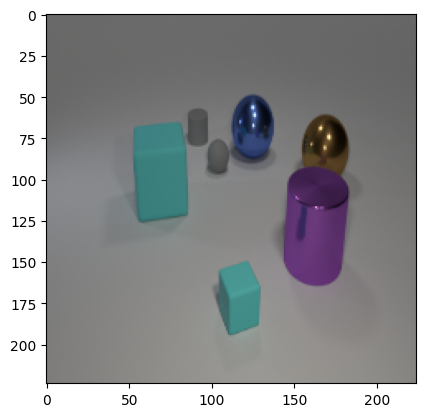

In [8]:
# First, we show the example image
plt.imshow(eg_i)
plt.show()

In [9]:
#Next, we show the example questions and answers for the image
l = eg_q.shape[0]
for combo in range(l):
    tf.print("Question:", eg_q[combo])
    tf.print("Answer:", eg_a[combo], "\n")

Question: "The blue metal object is what size?"
Answer: "large" 

Question: "What is the material of the small cyan cube?"
Answer: "rubber" 

Question: "Is the size of the cyan thing that is in front of the purple cylinder the same as the small matte ball?"
Answer: "yes" 

Question: "What number of things are either gray balls or big yellow metal objects?"
Answer: "1" 

Question: "There is a rubber object that is the same color as the large block; what is its shape?"
Answer: "cube" 

Question: "There is a shiny thing that is on the left side of the big brown thing and behind the large cyan thing; what size is it?"
Answer: "large" 

Question: "What number of tiny yellow metal cylinders are there?"
Answer: "0" 

Question: "How many blocks are either tiny cyan rubber things or small matte things?"
Answer: "1" 

Question: "There is a blue ball right of the cyan block that is behind the purple thing; how many brown objects are to the right of it?"
Answer: "1" 

Question: "The cylinder that 

b) The training and validation Datasets should be processed as follows:

* The image pixel values should be scaled to the interval $[0, 1]$.
* The answers should be (sparse) encoded as integer labels. You will need to compute the total number of distinct answers to do this.
* The questions should be tokenized and represented as a sequence of integer tokens. The questions should be split on whitespace and standardized by lowercasing and removing punctuation. 
* A single question-answer pair should be uniformly sampled from the available questions and answers for each image (so each image should appear exactly once per epoch with a single question-answer pair).
* The inputs to the model will be the question and the image. The targets will be the answer. Process the Datasets so that they return a tuple of 2 elements corresponding to inputs and targets.
* Shuffle the training Dataset, and batch both Datasets with batch size 64.

Print out the number of distinct answer labels, as well as the number of tokens in the vocabulary computed from the questions.

Print out the element_spec of one of the Datasets after processing. 

**(12 marks)**

In [10]:
#Scale the images
def image_scale(dic):
    im = dic["image"]
    im = im / 255
    dic["image"] = im
    return dic

train_ds = train_ds.map(image_scale)
val_ds = val_ds.map(image_scale)

In [11]:
### Sparse encode answers ###
#find number of unique answers
text_vectorization_ans = TextVectorization(standardize='lower_and_strip_punctuation',split = "whitespace")

#get answers for train set
answers = train_ds.map(lambda l: l["answer"])

#adapt on training set only
text_vectorization_ans.adapt(answers)

vocab_ans_size = text_vectorization_ans.vocabulary_size()
vocab_ans = text_vectorization_ans.get_vocabulary()
print(f"There are {vocab_ans_size} distinct answers including unknown and a placeholder")
print(vocab_ans)

#this shows that there are 30 unique answers, including unknown and placeholder "". 


There are 30 distinct answers including unknown and a placeholder
['', '[UNK]', 'no', 'yes', '1', '0', 'rubber', 'metal', 'small', 'large', '2', 'cylinder', 'sphere', 'cube', '3', 'blue', 'yellow', 'brown', 'gray', 'purple', 'cyan', 'red', 'green', '4', '5', '6', '7', '8', '9', '10']


In [12]:
#do sparse encoding as requested, we have [UNK] for OOV indices
stringlookup = StringLookup(vocabulary = vocab_ans, num_oov_indices=0)

def convert_labels(element):
    #update the dictionary given
    element["answer"] = stringlookup(element["answer"])
    return element

train_ds = train_ds.map(convert_labels)

#this will be the same for validation 

val_ds = val_ds.map(convert_labels)

In [13]:
### Now to tokenize all of the questions ###
text_vectorization_q = TextVectorization(standardize='lower_and_strip_punctuation',split = "whitespace")
#adapt to the questions of the training set
questions = train_ds.map(lambda l: l["question"])
text_vectorization_q.adapt(questions)
vocab_q_size = text_vectorization_q.vocabulary_size()
vocab_q = text_vectorization_q.get_vocabulary()

In [14]:
def tokenize_q(element):
    q = element["question"]
    element["question"] = text_vectorization_q(q)
    return element
#map it
train_ds = train_ds.map(tokenize_q)
val_ds = val_ds.map(tokenize_q)

In [15]:
### Now to sample randomly for each image ###

def sample_image(element):
    q, a = element["question"], element["answer"]
    #10 questions and answers per one
    num_qs = tf.shape(q)[0]
    #have to use tensorflow operation or it picks the same for all
    idx = tf.random.uniform(shape=(), minval=0, maxval=num_qs, dtype=tf.int32)
    q = q[idx,:]
    a = a[idx]
    element["question"] = q
    element["answer"] = a
    return element

train_ds = train_ds.map(sample_image)
val_ds = val_ds.map(sample_image)

In [16]:
### Now do inputs and targets ###
def inputs_and_targets(element):
    inputs = (element["question"], element["image"])
    targets = element["answer"]
    return inputs, targets

train_ds = train_ds.map(inputs_and_targets)
val_ds = val_ds.map(inputs_and_targets)


In [17]:
### Now shuffle and batch ###
#only shuffe training set as stated on ED
batch_size = 64
train_ds = train_ds.shuffle(100)

#padded batching to make sure the inputs are all of the same shape for each batch
train_ds = train_ds.padded_batch(batch_size)
val_ds = val_ds.padded_batch(batch_size)


In [18]:
#finally, prefetch
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [19]:
### Print off element specs ###

print(train_ds.element_spec)


((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


### Question 2 (Total 35 marks)

The model that you will implement for the visual question answering task was first proposed in the paper

* Perez, E., Strub, F., de Vries, H. & Courville, A. (2018), "FiLM: visual reasoning with a general conditioning layer", in _Proceedings of the Thirty-Second AAAI Conference on Artificial Intelligence_, New Orleans, Louisiana, USA.

The main idea is the introduction of a specialised layer called a FiLM layer (Feature-wise Linear Modulation). The purpose of this layer is to modify the predictions that are made by a CNN prediction model (the central stack coloured in brown in the figure below). The CNN prediction model takes the image as input, and outputs a categorical distribution over the set of possible answers.

The FiLM layer uses information stored in a vector embedding (which comes from the question text) to modify the post-activations of the CNN prediction model. This vector embedding is produced by a gated recurrent unit (GRU) network (referred to in the original paper as the FiLM generator) as the final hidden layer representation after processing the input question. This vector embedding is also referred to as the conditioning signal.

The overall model architecture is shown in the figure below:

<center><img src="figures/model.png" alt="Model architecture" style="width: 450px;"/></center>
<center>Overall model architecture</center>

The question is tokenized, and learned embeddings are processed sequentially by the GRU network/FiLM generator. There are potentially multiple FiLM layers within the CNN prediction model. Each FiLM layer uses the GRU embedding $\mathbf{q}$ (the conditioning signal) to modify the output of a convolutional layer within the CNN prediction model, as described in part c).

a) Implement the FiLM generator as a 2-layer stacked GRU network, using an embedding dimension of 64, and 128 neurons for both of the layers of the GRU. The network should output the final 128-dimensional embedding. Print the model summary.

**(3 marks)**

In [20]:
#we implement a function to get the generator for use later
def get_gru():
    gru_network = Sequential([
        #embed
        Embedding(input_dim = vocab_q_size,output_dim = 64,mask_zero = True),
        GRU(units = 128, return_sequences = True),
        GRU(units = 128)
    ], name = "gru_network")
    return gru_network

In [21]:
gru_network = get_gru()
gru_network.summary()

Model: "gru_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          5248      
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
Total params: 178,816
Trainable params: 178,816
Non-trainable params: 0
_________________________________________________________________


b) The first block of the CNN prediction model is a feature extractor CNN which does not make use of the conditioning signal $\mathbf{q}$ from the GRU network. This block takes the image as input, and passes it through two sub-blocks, each consisting of the following layers:

* A 2D convolutional layer with 128 filters, a 4x4 kernel, 2x2 strides, 'SAME' padding, and no activation function
* A batch normalisation layer
* An element-wise ReLU activation

Implement the feature extractor CNN and print the model summary.

**(2 marks)**

In [22]:
def get_cnn_feature_extractor():
    cnn_feature_extractor = Sequential([
        #sub block one
        Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", input_shape = (224,224,3)),
        BatchNormalization(),
        Activation("relu"),
        #sub block two
        Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same"),
        BatchNormalization(),
        Activation("relu")], name = "feature_extractor")
    return cnn_feature_extractor


In [23]:
cnn_feature_extractor = get_cnn_feature_extractor()
print(cnn_feature_extractor.summary())

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 128)     6272      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       262272    
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 56, 56, 128) 

c) Implement a custom layer class for the FiLM layer as described below. This class should subclass the base `Layer` class in the `tensorflow.keras.layers` module. 

This layer will need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$. 

The FiLM layer passes the conditioning signal $\mathbf{q}$ output by the GRU FiLM generator through a linear layer (dense layer with no activation function) to produce $\gamma$ and $\beta$:

$$
\gamma = \textrm{Linear}(\mathbf{q}) \quad\quad \beta = \textrm{Linear}(\mathbf{q}).
$$

Both $\gamma$ and $\beta$ are vectors, with length equal to the number of feature maps (or channels) in the output of a convolutional layer $\mathbf{h}$. These post-activations are then modulated via the feature-wise affine transformation:

$$
\textrm{FiLM}(\mathbf{h} | \gamma, \beta)_{h, w, c} = \gamma_c \mathbf{h}_{h, w, c} + \beta_c,
$$
where the subscripts $h, w, c$ index the height, width and channel dimensions respectively.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(10 marks)**

In [24]:
#the output channels of the convolutional network is 128
output_channels = 128
class FiLM(Layer):
    def __init__(self):
        super().__init__()
        #initialise the linear transformations so the weights can then be learned from this point onwards
        #we only want the given term, not the bias too
        self.dense_gamma = Dense(output_channels, name = "gamma", use_bias = False)
        self.dense_beta = Dense(output_channels, name = "beta", use_bias = False)
        
        
    def call(self,q,h):
        gamma = self.dense_gamma(q)
        beta = self.dense_beta(q)
        #return broadcasted result, could have done [None, etc]
        return tf.expand_dims(tf.expand_dims(gamma,1),1) * h + tf.expand_dims(tf.expand_dims(beta,1),1)
        

In [25]:
film = FiLM()

In [26]:
#take dummy data
#take the first example batch for each
for ele in train_ds.take(1):
    inputs, outputs = ele

print(film(gru_network(inputs[0]),cnn_feature_extractor(inputs[1])))
film(gru_network(inputs[0]), cnn_feature_extractor(inputs[1])).shape
#this gives us the shape that we expect

tf.Tensor(
[[[[-0.00394472 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00356205]
   [-0.00387035 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00333774]
   [-0.00387053 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00333535]
   ...
   [-0.00386849 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00333785]
   [-0.00386934 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00333516]
   [-0.00382091 -0.0047873   0.00574359 ...  0.00930811  0.00647941
     0.00326752]]

  [[-0.00405313 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00333494]
   [-0.00408463 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00326752]
   [-0.00408581 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00326752]
   ...
   [-0.00407638 -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00326752]
   [-0.0040761  -0.0047873   0.00574359 ...  0.00930811  0.00644133
     0.00326752]
   [-0.00397438 -0.0047873   0.0057435

TensorShape([64, 56, 56, 128])

d) The second main block of the CNN network consists of a number of ResBlocks. Each ResBlock consists of the following layers:

<center><img src="figures/resblock.png" alt="ResBlock" style="width: 150px;"/></center>


* A 1x1 convolutional layer with 128 channels and ReLU activation function
* A 3x3 convolutional layer with 128 channels and no activation function
* A BatchNormalization layer, where the usual $\gamma$ and $\beta$ parameters are not used
* a FiLM layer, that also uses the conditioning signal $\mathbf{q}$ from the GRU network
* An elementwise ReLU activation function
* The output is then added to the output of the first convolutional layer

Each convolutional layer uses 'SAME' padding.

Implement the ResBlock as another custom layer. Similar to the FiLM layer, this layer will also need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$. 

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(8 marks)**

In [27]:
class ResBlock(Layer):
    def __init__(self):
        super().__init__()
        #dont need to give conv the input dimension
        self.conv1 = Conv2D(128, (1,1), activation = "relu", padding = "same")
        self.conv2 = Conv2D(128,(3,3), padding = "same")
        #turn the bn parameters off for the bn layer preceeding the film layer
        self.bn = BatchNormalization(center = False, scale = False)
        self.film = FiLM()
        self.relu = Activation("relu")
    def call(self, q, h):
        #send the inputs forward, noting that the first convolutional layer is defined with Relu
        h = self.conv1(h)
        #save the output of the first convolutional layer for later
        conv1_h = h
        #proceed forward
        h = self.conv2(h)
        h = self.bn(h)
        h = self.film(q,h)
        h = self.relu(h)
        #now combine 
        h = h + conv1_h
        return h

In [28]:
#We will pass in the first example input again as before:
resblock = ResBlock()
print(resblock(gru_network(inputs[0]),cnn_feature_extractor(inputs[1])))
resblock(gru_network(inputs[0]),cnn_feature_extractor(inputs[1])).shape
#again we have the output dimension that we expect

tf.Tensor(
[[[[0.00238402 0.00740612 0.01181587 ... 0.02839302 0.01096677
    0.03112508]
   [0.00238679 0.00737248 0.03101223 ... 0.04915722 0.00929459
    0.01126014]
   [0.00238517 0.00735669 0.03069619 ... 0.04861517 0.00957751
    0.01114128]
   ...
   [0.00238486 0.00735818 0.02971518 ... 0.04711586 0.00852732
    0.01057689]
   [0.00237354 0.00735996 0.02945353 ... 0.04700648 0.00875173
    0.01056059]
   [0.00237347 0.00736589 0.03252681 ... 0.0239896  0.02310978
    0.01273261]]

  [[0.00235578 0.02687984 0.         ... 0.04914786 0.0452711
    0.        ]
   [0.00234912 0.00735517 0.01721121 ... 0.07691336 0.06987898
    0.        ]
   [0.00235232 0.00731229 0.01732242 ... 0.07720447 0.07021696
    0.        ]
   ...
   [0.00235331 0.00731583 0.01630605 ... 0.07388415 0.06744223
    0.        ]
   [0.00234766 0.00733835 0.01642369 ... 0.07393333 0.06750298
    0.        ]
   [0.00236107 0.00732006 0.01511    ... 0.04664368 0.06300981
    0.01124781]]

  [[0.00235672 0.0266567

TensorShape([64, 56, 56, 128])

e) At several points in the model, two coordinate feature maps will be added to the output of a convolutional layer. This operation will be applied before each ResBlock and the classifier component of the CNN prediction model. 

These two feature maps indicate relative $x$ and $y$ spatial position, and are each scaled from $-1$ to $1$ across the height and width dimensions. These two feature maps are concatenated as two extra channels to the convolutional layer output.

Implement this operation as another custom layer class called `AddSpatialCoordinates`. The layer should be able to accept input Tensors with arbitrary height, width and channel dimensions. This custom layer will not have any trainable variables.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(7 marks)**

In [29]:
class AddSpatialCoordinates(Layer):
    def __init__(self, name = "ASC"):
        super().__init__(name = name)
        
    def call(self,inputs):
        #here, inputs is the (batch,w,h,channel) tensor
        #[0] is batch size and [3] is number of channels
        x_size = inputs.shape[1]
        y_size = inputs.shape[2]

        x_grid = tf.linspace(-1,1,num = x_size)
        y_grid = tf.linspace(-1,1,num = y_size)
        #make these grids float32 to be compatible with the inputs tensor
        x_grid = tf.cast(x_grid,tf.float32)
        y_grid = tf.cast(y_grid,tf.float32)
        #this makes a list of two grids, -1 for x is left, -1 for y is top
        mesh = tf.meshgrid(x_grid,y_grid)
        #now we have to broadcast mesh so that we can add it to the inputs tensor
        mesh_x = mesh[0]
        mesh_y = mesh[1]
        mesh_x = tf.expand_dims(tf.expand_dims(mesh_x,0),-1)
        mesh_y = tf.expand_dims(tf.expand_dims(mesh_y,0),-1)
        #now tile to commute with the batch size
        mesh_x = tf.tile(mesh_x, [tf.shape(inputs)[0],1,1,1])
        mesh_y = tf.tile(mesh_y, [tf.shape(inputs)[0],1,1,1])
        inputs = tf.concat([inputs,mesh_x,mesh_y],axis = -1)
        return inputs
        

In [30]:
#Again test this on the example input:
asc = AddSpatialCoordinates()
test = asc(cnn_feature_extractor(inputs[1]))
print(test.shape)
#this is giving what we expect, with the two added dimensions for channel

(64, 56, 56, 130)


In [31]:
#lets inspect the final two dimensions of this, for the first example in the batch
print(test[0,:,:,-1])
print(test[0,:,:,-2])
#this is the relative positionings for each one as we eould expect

tf.Tensor(
[[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.96363634 -0.96363634 -0.96363634 ... -0.96363634 -0.96363634
  -0.96363634]
 [-0.92727274 -0.92727274 -0.92727274 ... -0.92727274 -0.92727274
  -0.92727274]
 ...
 [ 0.92727274  0.92727274  0.92727274 ...  0.92727274  0.92727274
   0.92727274]
 [ 0.96363634  0.96363634  0.96363634 ...  0.96363634  0.96363634
   0.96363634]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]], shape=(56, 56), dtype=float32)
tf.Tensor(
[[-1.         -0.96363634 -0.92727274 ...  0.92727274  0.96363634
   1.        ]
 [-1.         -0.96363634 -0.92727274 ...  0.92727274  0.96363634
   1.        ]
 [-1.         -0.96363634 -0.92727274 ...  0.92727274  0.96363634
   1.        ]
 ...
 [-1.         -0.96363634 -0.92727274 ...  0.92727274  0.96363634
   1.        ]
 [-1.         -0.96363634 -0.92727274 ...  0.92727274  0.96363634
   1.        ]
 [-1.         -0.96363634 -0.92727274 ...  0.92727274  0.963

f) The final main block of the CNN network is a classifier block. This block consists of the following layers:

* 1x1 convolution with 512 output channels, ReLU activation, and 'SAME' padding
* Global max pooling across height and width dimensions
* Dense layer with 512 neurons and ReLU activation
* Final Dense layer with $n_c$ neurons and softmax activation, where $n_c$ is the number of output labels

Once you have implemented the classifier, you should bring all components together to build the complete model. This model consists of the following:

* GRU FiLM generator as defined in part a) that processes the sequence of question tokens and outputs an embedding $\mathbf{q}$ of dimension 128
* Feature extractor block as defined in part b) that processes the input image
* The output of the feature extractor should then be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* This should be followed by just one ResBlock custom layer, that takes in two inputs: the output from the previous `AddSpatialCoordinates` layer and the question embedding $\mathbf{q}$. We will only use one ResBlock due to computational limitations
* The output of the ResBlock should then also be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* The output from the previous `AddSpatialCoordinates` layer should then be sent through the classifier block to obtain the final output prediction

Implement the complete model according to the above spec, and print the model summary.

**(5 marks)**

In [32]:
def get_classifier():
    classifier = Sequential([
        #dont need to specify input size for conv2d
        Conv2D(512,(1,1), activation = "relu", padding = "same"),
        #looking at documentation, this globally pools over height and width, leaving batch and channels intact
        GlobalMaxPooling2D(),
        Dense(512,activation = "relu"),
        Dense(vocab_ans_size, activation = "softmax")], name = "classifier")
    return classifier

In [33]:
class full_model(Model):
    def __init__(self):
        super(full_model,self).__init__()
        self.gru = get_gru()
        self.feature_extractor = get_cnn_feature_extractor()
        #asp can be called multiple times since not trained
        self.asp = AddSpatialCoordinates()
        self.resblock = ResBlock()
        self.classifier = get_classifier()
    def call(self,inputs):
        #we expect just the input to be passed in, not the target
        text, images = inputs
        q = self.gru(text)
        h = self.feature_extractor(images)
        h = self.asp(h)
        h = self.resblock(q,h)
        h = self.asp(h)
        #predict
        preds = self.classifier(h)
        return preds
        

In [34]:
#to print the model summary we call it on the example
fm = full_model()
print(fm(inputs))
fm(inputs).shape
#we expected this shape, since the batch is 64 and there were 30 possible answers
#and each of the 30 have a roughly equal chance, which makes sense since the model has been initialised but not trained


tf.Tensor(
[[0.03206209 0.03023569 0.04686745 ... 0.03364512 0.0383742  0.02747775]
 [0.0320677  0.03036618 0.0469934  ... 0.03357996 0.03850182 0.02734053]
 [0.0320782  0.03024117 0.0470595  ... 0.03358467 0.03857011 0.02739289]
 ...
 [0.03203578 0.03035682 0.04688934 ... 0.03358771 0.03846231 0.02732208]
 [0.03208403 0.03027789 0.04689825 ... 0.03359709 0.03853745 0.02747268]
 [0.03201549 0.03013543 0.04685825 ... 0.03358852 0.0384712  0.02738458]], shape=(64, 30), dtype=float32)


TensorShape([64, 30])

In [35]:
fm.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_network (Sequential)    (None, 128)               178816    
                                                                 
 feature_extractor (Sequenti  (None, 56, 56, 128)      269568    
 al)                                                             
                                                                 
 ASC (AddSpatialCoordinates)  multiple                 0         
                                                                 
 res_block_1 (ResBlock)      multiple                  197376    
                                                                 
 classifier (Sequential)     (64, 30)                  345118    
                                                                 
Total params: 990,878
Trainable params: 990,110
Non-trainable params: 768
________________________________________________

### Question 3 (Total 30 marks)

a) You should now train your model from question 2 using a cross entropy loss function. Train the model for 20 epochs, with an Adam optimizer with learning rate 3e-4. You should track model performance on the validation set, including the accuracy. 

Your code should be structured to account for restarting broken training runs. You will need to save your model every epoch, and save all of the model's training and validation performance up to that point (a convenient method is to use the `CSVLogger` callback). In the case of a broken training run, the required data should be loaded, and the training run resumed from the last saved checkpoint. You do not need to use early stopping in the training run.

When training has completed, compute and print the final evaluation of your model on the validation set.

_NB: The model would need to be larger and trained for longer to achieve good performance on this task. The model and training have been scaled down to accommodate infrastructure limitations on the Coursera platform. You should implement the architecture as specified in this assessment, but you can train the model for longer if you wish. The performance of the resulting model is **not** part of the marking criteria._

**(15 marks)**

In [36]:
#setup optimizer and callback
optimizer = Adam(lr = 3e-4)
# callback to save training and validation performance in case of broken runs
logger = CSVLogger("epoch_log.csv", separator = ",", append = True)
# callback to save the model every epoch, but only record the best to avoid having too big of a file, and we only save the weights
#model performance is to be tracked on the validation loss, but still include accuracy, so monitor validation loss
ckpt = ModelCheckpoint("best_model.h5", monitor = "val_loss", save_best_only= True, mode = "min", save_weights_only=True)
fm.compile(loss = "SparseCategoricalCrossentropy", optimizer = optimizer,metrics = ["accuracy"])

d:\University-local\Imperial\Term 2\Deep Learning\.conda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
fm_history = fm.fit(train_ds,epochs = 20, validation_data = val_ds, callbacks = [logger,ckpt])

Epoch 1/20


234/234 [==============================] - 48s 169ms/step - loss: 2.0546 - accuracy: 0.2856 - val_loss: 1.9809 - val_accuracy: 0.3432
Epoch 2/20
234/234 [==============================] - 36s 153ms/step - loss: 1.3256 - accuracy: 0.3791 - val_loss: 1.2824 - val_accuracy: 0.4155
Epoch 3/20
234/234 [==============================] - 36s 154ms/step - loss: 1.0969 - accuracy: 0.4296 - val_loss: 1.0822 - val_accuracy: 0.4275
Epoch 4/20
234/234 [==============================] - 38s 163ms/step - loss: 1.0667 - accuracy: 0.4258 - val_loss: 1.0573 - val_accuracy: 0.4429
Epoch 5/20
234/234 [==============================] - 39s 164ms/step - loss: 1.0480 - accuracy: 0.4372 - val_loss: 1.0134 - val_accuracy: 0.4555
Epoch 6/20
234/234 [==============================] - 35s 149ms/step - loss: 1.0276 - accuracy: 0.4405 - val_loss: 1.0190 - val_accuracy: 0.4411
Epoch 7/20
234/234 [==============================] - 35s 150ms/step - loss: 1.0143 - accuracy: 0.4415 - val_loss: 1.0182 - val_accuracy: 0.4

In [38]:
# I had issues where if I saved the entire best model and then loaded it, on a fresh notebook it would give low accuracy, so I opted to just save the weights, then this cell loads the weights and it works


#test the best model on the validation set (as stated on ED)
#we do so by loading from the file, to ensure it can be rexecuted if needed
best_model = full_model()
#initialize
best_model(inputs)
#compile and load weights
best_model.compile(loss = "SparseCategoricalCrossentropy", optimizer = optimizer,metrics = ["accuracy"])
best_model.load_weights("best_model.h5")
best_model.evaluate(val_ds)

59/59 [==============================] - 7s 60ms/step - loss: 0.9377 - accuracy: 0.4587


[0.9377139806747437, 0.4586666524410248]

b) Plot the loss and accuracy over the course of training on the training and validation sets.

Select at least one sample image and question from the validation set, and compute the model predictions. Display the image, question, ground truth answer and model predictive distribution over the set of answers.

**(7 marks)**

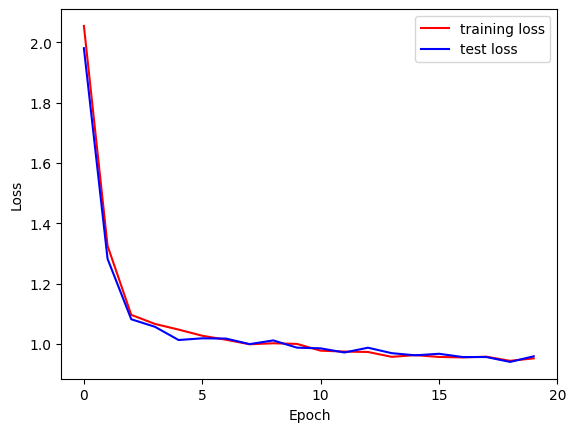

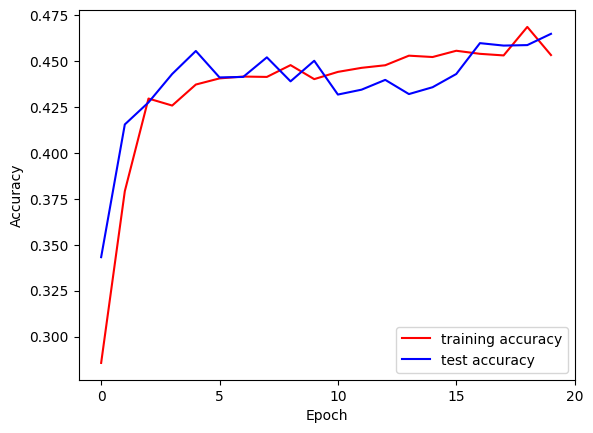

In [39]:

plt.plot(fm_history.history["loss"], "r", label = "training loss")
plt.plot(fm_history.history["val_loss"],"b",label = "test loss")
plt.xlabel("Epoch")
plt.xticks([0,5,10,15,20])
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(fm_history.history["accuracy"], "r", label = "training accuracy")
plt.plot(fm_history.history["val_accuracy"],"b",label = "test accuracy")
plt.xlabel("Epoch")
plt.xticks([0,5,10,15,20])
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Next, we pick a random question from the validation set and predict the response:

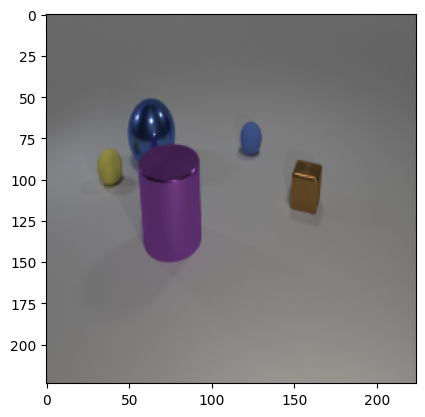

Question: Do the yellow sphere and the metal object that is behind the metallic block have the same size?
Answer: no


In [40]:
#select a batch
for ele in val_ds.take(1):
    eg, eg_a= ele[0], ele[1]
#randomly select an item from the batch
r = np.random.randint(0,eg_a.shape[0]-1)

eg_q,eg_i= eg[0][r], eg[1][r]
eg_a = eg_a[r]
plt.imshow(eg_i)
plt.show()

#print question 
eg_q_words = [vocab_q[idx] for idx in eg_q if idx != 0]
eg_q_words[0] = eg_q_words[0].capitalize()
eg_q_sentence = ' '.join(word for word in eg_q_words)
print(f"Question: {eg_q_sentence}?")
print(f"Answer: {vocab_ans[eg_a]}")


Now, for the predicted response, and predictive categorical distribution:

In [41]:
pred = fm.predict((eg_q[None,:],eg_i[None,:])).squeeze(0) 
print(f"Predicted answer: {vocab_ans[tf.argmax(pred)]}")


1/1 [==============================] - 2s 2s/step
Predicted answer: no


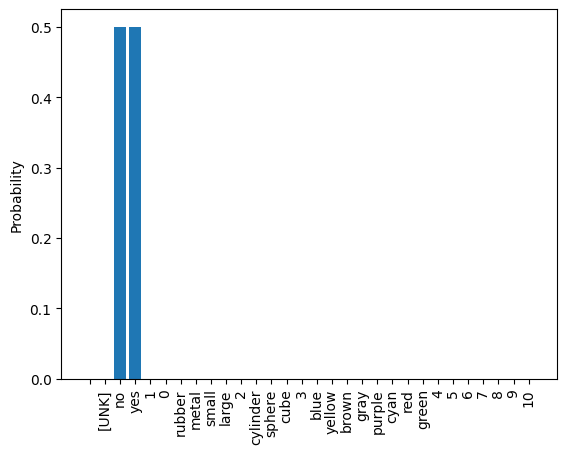

In [42]:
plt.bar(vocab_ans, pred)
plt.xticks(rotation=90)
plt.ylabel("Probability")
plt.show()

In [43]:
#predictive distribution as a table, we do as 3 in order to fully show
table = [[vocab_ans[i],pred[i]] for i in range(10)]
print(tabulate(table, headers = ["Response","Probability"],tablefmt = "fancy_grid"))

╒════════════╤═══════════════╕
│ Response   │   Probability │
╞════════════╪═══════════════╡
│            │   3.05033e-08 │
├────────────┼───────────────┤
│ [UNK]      │   2.76312e-08 │
├────────────┼───────────────┤
│ no         │   0.500041    │
├────────────┼───────────────┤
│ yes        │   0.499763    │
├────────────┼───────────────┤
│ 1          │   3.23345e-05 │
├────────────┼───────────────┤
│ 0          │   2.59166e-05 │
├────────────┼───────────────┤
│ rubber     │   5.74105e-07 │
├────────────┼───────────────┤
│ metal      │   1.0419e-06  │
├────────────┼───────────────┤
│ small      │   2.05424e-05 │
├────────────┼───────────────┤
│ large      │   1.5781e-05  │
╘════════════╧═══════════════╛


In [44]:
table = [[vocab_ans[i],pred[i]] for i in range(10,20)]
print(tabulate(table, headers = ["Response","Probability"],tablefmt = "fancy_grid"))

╒════════════╤═══════════════╕
│ Response   │   Probability │
╞════════════╪═══════════════╡
│ 2          │   1.78211e-05 │
├────────────┼───────────────┤
│ cylinder   │   2.03542e-06 │
├────────────┼───────────────┤
│ sphere     │   4.24522e-06 │
├────────────┼───────────────┤
│ cube       │   2.26384e-06 │
├────────────┼───────────────┤
│ 3          │   9.57441e-06 │
├────────────┼───────────────┤
│ blue       │   6.6474e-06  │
├────────────┼───────────────┤
│ yellow     │   7.50079e-06 │
├────────────┼───────────────┤
│ brown      │   8.13632e-06 │
├────────────┼───────────────┤
│ gray       │   5.20654e-06 │
├────────────┼───────────────┤
│ purple     │   9.6281e-06  │
╘════════════╧═══════════════╛


In [45]:
table = [[vocab_ans[i],pred[i]] for i in range(20,30)]
print(tabulate(table, headers = ["Response","Probability"],tablefmt = "fancy_grid"))

╒════════════╤═══════════════╕
│ Response   │   Probability │
╞════════════╪═══════════════╡
│ cyan       │   6.34695e-06 │
├────────────┼───────────────┤
│ red        │   6.42977e-06 │
├────────────┼───────────────┤
│ green      │   3.78207e-06 │
├────────────┼───────────────┤
│ 4          │   5.58822e-06 │
├────────────┼───────────────┤
│ 5          │   2.89542e-06 │
├────────────┼───────────────┤
│ 6          │   6.24316e-07 │
├────────────┼───────────────┤
│ 7          │   4.83194e-07 │
├────────────┼───────────────┤
│ 8          │   1.15183e-07 │
├────────────┼───────────────┤
│ 9          │   1.51027e-07 │
├────────────┼───────────────┤
│ 10         │   2.55918e-08 │
╘════════════╧═══════════════╛


c) Explain why adding spatial coordinate feature maps as in 2e) is beneficial for the proposed model and task from questions 1 and 2.

**(3 marks)**

It is beneficial because in the context of the questions asked about each image, relative positions of the different objects are crucial to answering the questions correctly. In usual image detection, the CNN can simply learn edges and then other features, without caring too much about where different objects in the image are in relation to each other, since they were made with translation invariance in mind. However, when the learning task requires these relative positionings within the image, the spacial coordinate feature maps are incredibly helpful, since they provide the model with the local information needed so it can learn relative positionings in relation to the words "left", "right", "behind" etc. It also helps with differentiating between two similar looking objects that are located within different parts of the image (which is very important in the context of the dataset questions).

d) An alternative method to FiLM to incorporate conditioning information would be to concatenate the conditional embedding $\mathbf{q}$ with the channel dimension in a convolutional layer input $\mathbf{h}^{(k-1)}$ at every spatial location (in other words, concatenate constant feature maps with the input $\mathbf{h}^{(k-1)}$ to a convolutional layer). 

Explain how this method would compare in terms of computation and parameter efficiency with applying the FiLM layer computation outlined in 2c) to the output $\mathbf{h}^{(k)}$ of the convolutional layer. You can assume the convolutional layer has no activation function.

**(5 marks)**

The FiLM layer shifts and scales the prior output from the batch normalisation layer coming from the CNN part of the block. The shift and scale are aquired via two separate linear layers with the signal q from the GRU part of the network. These linear layers would have parameters that have to be learned within the FiLM layer. The alternative method concatenates q with h before h goes through the convolutional layer. These two methods would have different numbers of parameters, and different computational costs.

Firstly, increasing the channel dimension of h by concatenating q is going to increase the computational time, especially considering this is a convolutional layer. Concatenating the conditional embedding at every spatial location means the shape of the tensor would go from (H,W,C) to (H,W,C+D) where C is the number of channels h has before, and D is the dimension of the conditional embedding. In our case, this means an increase in channel dimension from 128 to 256. It comes down to a comparison of the computations required for doubling the channel dimension going into the convolutional layer, and the FiLM layer. In general, considering the kernel shape can be increased and changed, this would lead to more computations required, than the pretty much fixed number required for the FiLM layer. Thus, in general, FiLM is more efficient computationally.

As for parameter efficiency, the FiLM layer introduces a $\gamma$ and a $\beta$ for each channel of the incoming output $\mathbf{h}^{(k)}$ of the convolutional layer. This means, assuming a fully connected linear layer for each (with no biases), there would be $128^2 \times 2 = 32768$ parameters to be learned using the FiLM layer. However, if instead the second method was used, concatenating q and h at every spacial location before the convolutional layer, this would result in a channel dimension of $128 + 128 = 256$. Now the number of parameters would depend on the convolutional layer used, but for arguments sake, lets take the first convolutional layer in the resblock. This has 128 filters and a kernel size of 1x1. Then we are comparing inputs with the same height, width, and batch dimensions, but differet numbers of channels. The FiLM layer method would have 128 channels at this point, resulting in $128 \times 128 + 128 = 16512$ parameters to be learned (including bias here), whereas the alternative method would have 256 channels, resulting in $256 \times 128 + 128 = 32,896$ parameters to be learned (again including bias). However, the FiLM layer has the additional parameters to be learned from the layer itself, resulting in $49280$ parameters to learned in total, meaning a difference of $16384$ parameters between the two methods. This was done for the first convolutional layer in the resblock, but generally, using the alternative doubles the number of parameters (before including the bias terms) in the convolutional layer, but doesn't have the parameters to be learned in the FiLM layer. However, the number of parameters to be learned in the FiLM layer can be considered fixed, assuming the input channels remains constant. If the kernel size in the convolutional layer is increased, then then the number of parameters needed to be learned is increased, thus when the second method is used and this number is then doubled, it can lead to a much greater total number of parameters for the second method, compared to the first, even with the $32768$ less from not having the FiLM parameters. This can be seen below:

In [46]:
#Setup dummy inputs
for ele in train_ds.take(1):
    inputs, outputs = ele

q_test = gru_network(inputs[0])
h_test = cnn_feature_extractor(inputs[1])

#for FiLM layer, this is done after the Conv layer, so q would come later, but we already calculated the number of parameters introduced by this
q_test = q_test[:,None,None,:]
q_test = tf.tile(q_test,[1,56,56,1])
h_test_alternative = tf.concat([h_test,q_test],axis = -1)
print(h_test_alternative.shape)


(64, 56, 56, 256)


In [47]:
#summary for 
test_layer= Sequential([
    Conv2D(128, (1,1), activation = "relu", padding = "same")
])
test_layer(h_test)
print(test_layer.summary())

test_layer= Sequential([
    Conv2D(128, (1,1), activation = "relu", padding = "same")
])
test_layer(h_test_alternative)
print("---"*100, "\n")
print("ALTERATIVE METHOD:")
print(test_layer.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (64, 56, 56, 128)         16512     
                                                                 
Total params: 16,512
Trainable params: 16,512
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 

ALTERATIVE METHOD:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (64, 56, 56, 128)         32896     
                                 

In [48]:
# NOW FOR A BIGGER KERNEL
#summary for 
test_layer= Sequential([
    Conv2D(128, 10, activation = "relu", padding = "same")
])
test_layer(h_test)
print(test_layer.summary())

test_layer= Sequential([
    Conv2D(128, 10, activation = "relu", padding = "same")
])
test_layer(h_test_alternative)
print("---"*100, "\n")
print("ALTERATIVE METHOD:")
print(test_layer.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (64, 56, 56, 128)         1638528   
                                                                 
Total params: 1,638,528
Trainable params: 1,638,528
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 

ALTERATIVE METHOD:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (64, 56, 56, 128)         3276928   
                         

Hence again, in general, the FiLM layer is going to be more efficient with respect to the number of parameters needed.

### Question 4 (Total 10 marks)

Provide a separate PDF report with your evaluation and conclusions on the model and training results in this assessment.

In addition, compare the experiment conducted in this assessment with that described in section 2 of the [original paper](https://arxiv.org/abs/1709.07871). In particular, discuss how the model architecture and training algorithm differ.

Your report should be no more than 1 page.

**(10 marks)**